# Notebook for making plots for steering committee 2

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec


from importlib import reload

from scipy.stats import beta, spearmanr, rankdata
from datetime import datetime, date

import sys
sys.path.append('../')
from scripts.model_utils import (calc_look_ahead_stats, calculate_burst_number, get_client_features,
                                get_feature_matrix, get_current_referral_issues)

%load_ext autoreload
%autoreload 2

# Problem set-up
Load the data

In [2]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

clients = pd.read_csv('../../Welcome-Centre-DataCorps-Data/clients.csv', index_col=0)

referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])
    
referrals = referrals.sort_values('ReferralTakenDate')

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
referrals = referrals.pipe(calc_look_ahead_stats, window=365, break_length=28, break_coefficient=1)

In [12]:
referrals = referrals.pipe(calculate_burst_number,break_length=28)

### Plot the time series and score for a single client 

In [13]:
# Plot the score for a single client
def plot_time_series(referrals, client_id):
    for_plot = referrals[(referrals['ClientId']==client_id)]
                         #& (referrals['weeks'] >= 52)]
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.plot_date(x=for_plot['ReferralTakenDate'], y=[1 for i in range(len(for_plot))])
    ax1.plot_date(x=for_plot['ReferralTakenDate'], y=for_plot['future_referral_score'])
    ax1.set_ylim(0,1)
    ax0.set_xlim(date(2014,1,1), date(2017,4,1))
    ax1.set_xlim(date(2014,1,1), date(2017,4,1))
    ax1.set_ylabel('Future Referral Score')


In [14]:
referrals[referrals['ClientId']==10][['ReferralTakenDate', 'counts',
                                        'future_referral_score', 'gaps',
                                       'start_of_burst', 'burst_number', 'burst_length', 'index_in_burst',
       'has_had_previous_burst']]

,ReferralTakenDate,counts,future_referral_score,gaps,start_of_burst,burst_number,burst_length,index_in_burst,has_had_previous_burst
11,2014-01-13 00:00:00,4.0,0.057534,1.0,False,1.0,2.0,1.0,0
12,2014-02-03 00:00:00,3.0,0.038356,1.0,False,1.0,2.0,2.0,0
2739,2014-06-09 15:31:00,2.0,0.038356,0.0,True,2.0,3.0,1.0,1
2841,2014-06-16 15:46:00,1.0,0.019178,0.0,False,2.0,3.0,2.0,1
2981,2014-06-23 16:42:00,0.0,0.000000,0.0,False,2.0,3.0,3.0,1
15005,2016-10-18 11:24:00,2.0,0.038356,0.0,True,3.0,3.0,1.0,1
15342,2016-11-08 12:32:00,1.0,0.019178,0.0,False,3.0,3.0,2.0,1
15763,2016-12-02 14:09:00,0.0,0.000000,0.0,False,3.0,3.0,3.0,1


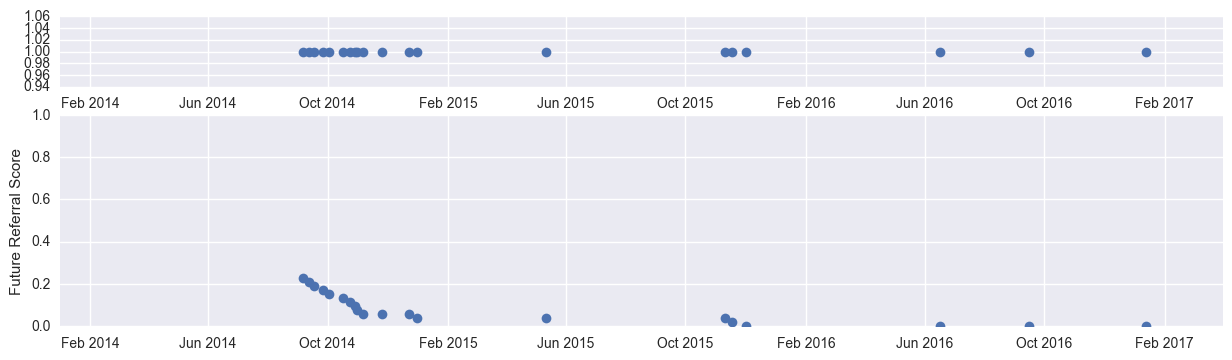

In [15]:
plot_time_series(referrals, 2261)

### Look at the correlation between features and score

In [30]:
# Generate full feature matrix
features = get_feature_matrix(referrals, clients)

In [31]:
for_corr = features.merge(referrals[['referral_no', 'future_referral_score']], left_index=True,
                         right_index=True)

for_corr = for_corr[~for_corr['future_referral_score'].isnull()]

In [33]:
spearmanr(for_corr['future_referral_score'], for_corr['referral_no'])

SpearmanrResult(correlation=0.35072619610284533, pvalue=0.0)

In [42]:
# Calculate Correlations
correlations = (for_corr.drop('future_referral_score', axis=1).apply(lambda k:spearmanr(for_corr['future_referral_score'], k)[0])
                        .sort_values().dropna())

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:2558: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = co

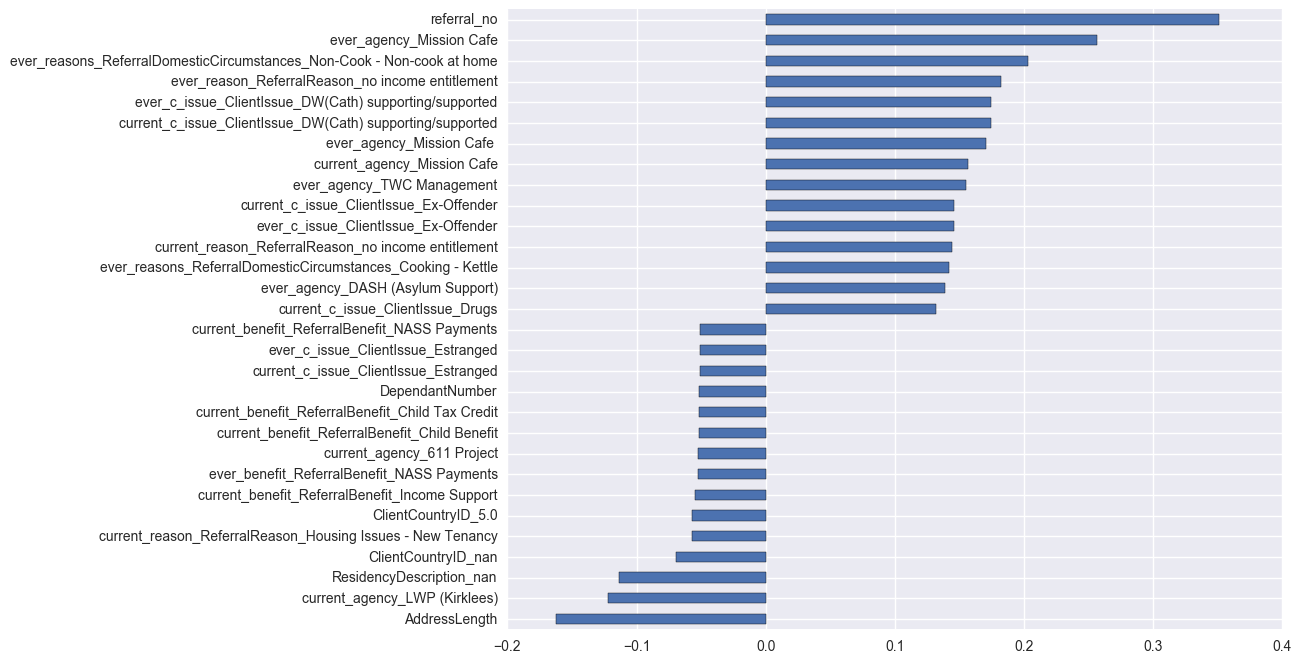

In [49]:
# Plot correlations
pd.concat([correlations.head(15), correlations.tail(15)]).plot(kind='barh', figsize=(10,8))

### Plot a subset of referral histories

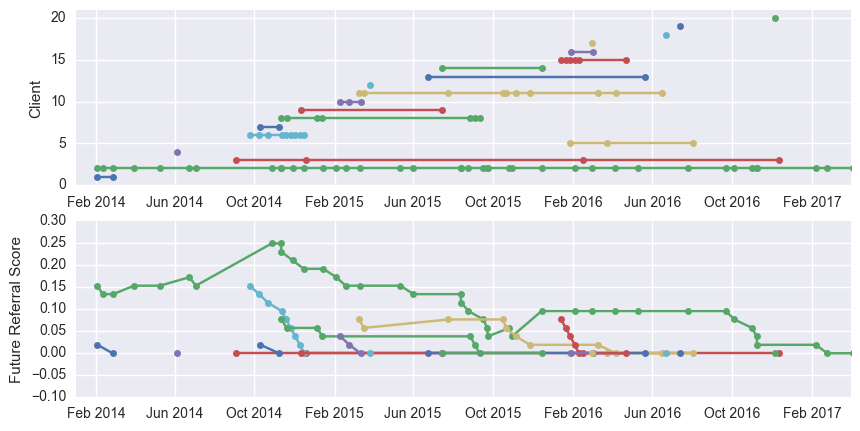

In [167]:
# Plot the score for a single client
def plot_time_series(referrals, client_ids_to_plot):
    for_plot = referrals[(referrals['ClientId'].isin(client_ids_to_plot))]
    fig = plt.figure(figsize=(15, 4))
    ax0 = plt.subplot(111)
    i = 1
    for k,g in for_plot.groupby('ClientId'):
        ax0.plot_date(x=g['ReferralTakenDate'], y=[i for j in range(len(g))])
        i += 1
    ax0.set_xlim(date(2014,1,1), date(2017,4,1))
    ax0.set_ylabel('Client')
    ax0.set_ylim(0, len(client_ids_to_plot) + 1)
    
# Plot the score for a single client
def plot_time_series_with_scores(referrals, client_ids_to_plot):
    for_plot = referrals[(referrals['ClientId'].isin(client_ids_to_plot))]
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    i = 1
    for_plot = for_plot.sample(frac=1)
    for k,g in for_plot.groupby('ClientId'):
        g = g.sort_values('ReferralTakenDate')
        ax0.plot_date(x=g['ReferralTakenDate'], y=[i for j in range(len(g))],markersize=5, linestyle='solid')
        ax1.plot_date(x=g['ReferralTakenDate'], y=g['future_referral_score'],
                     markersize=5, linestyle='solid')
        i += 1
    ax0.set_xlim(date(2014,1,1), date(2017,4,1))
    ax1.set_xlim(date(2014,1,1), date(2017,4,1))
    ax0.set_ylabel('Client')
    ax0.set_ylim(-0.1, len(client_ids_to_plot) + 1)
    ax1.set_ylim(-0.1, 0.3)
    ax1.set_ylabel('Future Referral Score')
    
plot_time_series_with_scores(referrals, referrals.groupby('ClientId').size().sample(20).index)

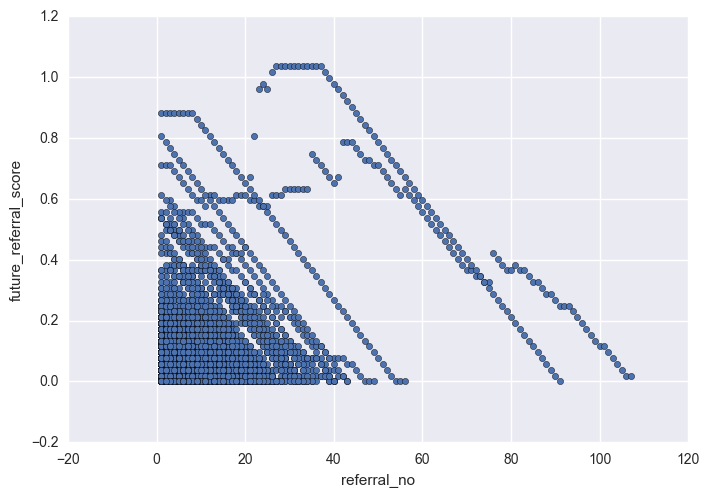

In [129]:
referrals.plot(kind='scatter', x='referral_no', y='future_referral_score')